In [1]:
#Installing the libraries for splitting up the folders
!pip install split-folders -q

In [2]:
!pip install tensorflow -q

In [3]:
#Import the necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import splitfolders
import os
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
print("All libraries are installed and imported succesfully")

All libraries are installed and imported succesfully


In [4]:
#Set up Kaggle API Key
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your 'kaggle.json' file.")
    uploaded = files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("APi key already exists.")

# Download and unzip the dataset if it doesn't exist
raw_data_dir = '/content/Citrus_Leaves_Raw'
if not os.path.exists(raw_data_dir):
    print("Downloading and unzipping the Citrus Leaf dataset...")
    !kaggle datasets download -d myprojectdictionary/citrus-leaf-disease-image -p /content
    !unzip -q /content/citrus-leaf-disease-image.zip -d {raw_data_dir}
    print("✅ Dataset is ready.")
else:
    print("Dataset already downloaded.")

APi key already exists.
Dataset already downloaded.


In [5]:
#spilt data into train, val and test set folder
input_folder = '/content/Citrus_Leaves_Raw/Citrus Leaf Disease Image'
output_folder = '/content/Citrus_Leaves_Split'
if not os.path.exists(output_folder):
    print("Splitting data into train, val, and test sets...")
    splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))
    print("data splitting complete")
else:
    print("Data already split.")

Data already split.


In [6]:
#Defining the directories and image parameters
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')
Image_height = 224
Image_width = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(Image_height, Image_width), batch_size=batch_size, class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    val_dir, target_size=(Image_height, Image_width), batch_size=batch_size, class_mode='categorical')

test_generator = train_datagen.flow_from_directory(
    test_dir, target_size=(Image_height, Image_width), batch_size=batch_size, class_mode='categorical')

print("Data generators are ready.")
print("Class Indices", test_generator.class_indices)

Found 423 images belonging to 5 classes.
Found 88 images belonging to 5 classes.
Found 96 images belonging to 5 classes.
Data generators are ready.
Class Indices {'Black spot': 0, 'Canker': 1, 'Greening': 2, 'Healthy': 3, 'Melanose': 4}


In [7]:
def build_model(base_model_class, num_classes):
    """Helper function to build a model with a given base."""

    base_model = base_model_class(input_shape=(Image_height, Image_width, 3),
                                  include_top=False,
                                  weights='imagenet')

    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

print("Building MobileNetV2 model...")
model_mobilenet = build_model(MobileNetV2, train_generator.num_classes)
model_mobilenet.summary()

print("\nBuilding InceptionV3 model...")
model_inception = build_model(InceptionV3, train_generator.num_classes)
model_inception.summary()

print("\n Both models are built and compiled successfully.")

Building MobileNetV2 model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,574,853 (13.64 MB)

 Trainable params: 1,316,869 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Building InceptionV3 model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)


 Both models are built and compiled successfully.


In [8]:
import time

EPOCHS = 10

print("--- Training MobileNetV2 ---")
start_time_mobile = time.time()

history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

end_time_mobile = time.time()
training_time_mobile = end_time_mobile - start_time_mobile
print(f"✅ MobileNetV2 training complete in {training_time_mobile / 60:.2f} minutes.")

print("\n--- Training InceptionV3 ---")
start_time_inception = time.time()

history_inception = model_inception.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

end_time_inception = time.time()
training_time_inception = end_time_inception - start_time_inception
print(f"✅ InceptionV3 training complete in {training_time_inception / 60:.2f} minutes.")

--- Training MobileNetV2 ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5069 - loss: 1.6038 - val_accuracy: 0.7614 - val_loss: 0.6456
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8540 - loss: 0.4082 - val_accuracy: 0.7955 - val_loss: 0.5516
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9295 - loss: 0.2043 - val_accuracy: 0.8295 - val_loss: 0.4797
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9528 - loss: 0.1497 - val_accuracy: 0.7614 - val_loss: 0.7094
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9099 - loss: 0.1693 - val_accuracy: 0.8523 - val_loss: 0.4754
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9817 - loss: 0.0694 - val_accuracy: 0.8295 - val_loss: 0.5044
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9973 - loss: 0.0402 - val_accuracy: 0.8523 - val_loss: 0.5412
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9978 - loss: 0.0280 - val_accuracy: 0.8295 - val_loss:

--- Displaying results for MobileNetV2 ---


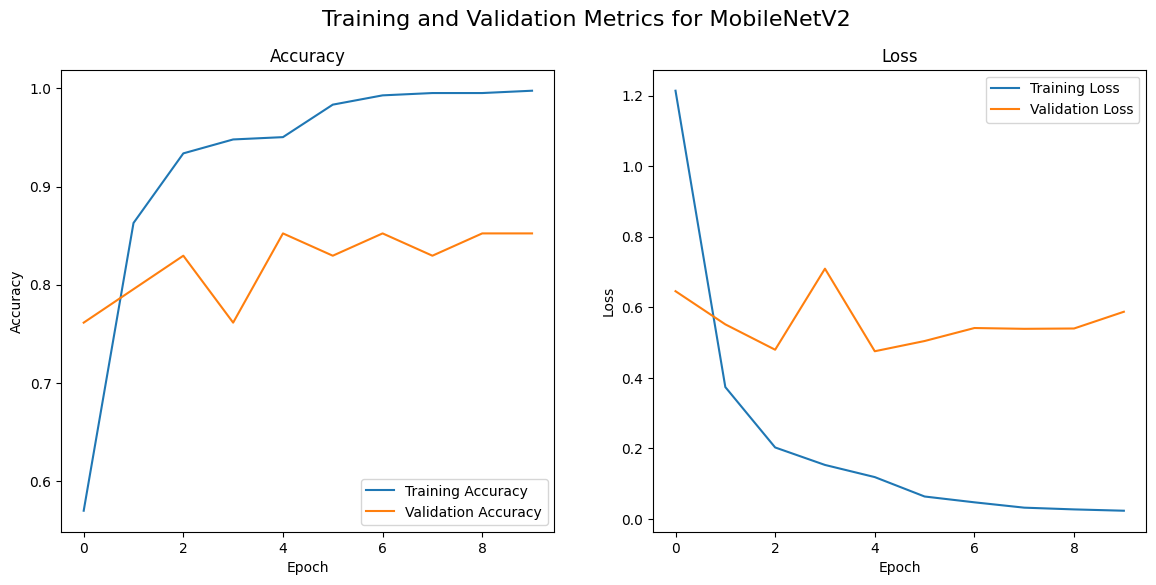


--- Displaying results for InceptionV3 ---


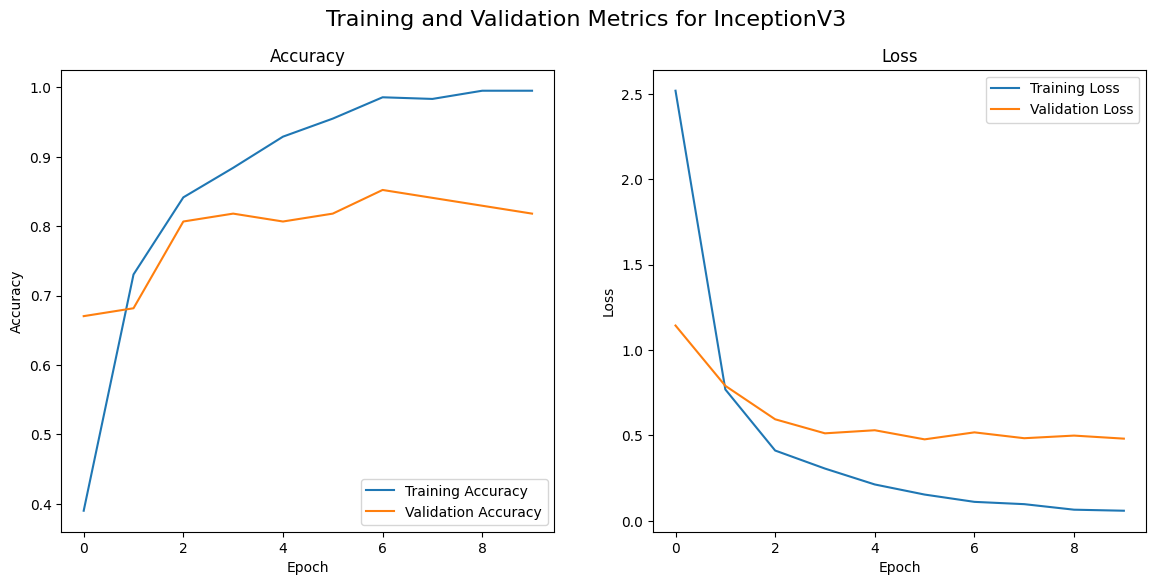

In [9]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """A helper function to plot the training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))
    plt.suptitle(f'Training and Validation Metrics for {model_name}', fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.show()

print("--- Displaying results for MobileNetV2 ---")
plot_history(history_mobilenet, "MobileNetV2")

print("\n--- Displaying results for InceptionV3 ---")
plot_history(history_inception, "InceptionV3")

In [10]:
print("--- Evaluating MobileNetV2 ---")
loss_mobile, acc_mobile = model_mobilenet.evaluate(test_generator)

print("\n--- Evaluating InceptionV3 ---")
loss_inception, acc_inception = model_inception.evaluate(test_generator)

model_mobilenet.save('mobilenet.h5')
model_inception.save('inceptionv3.h5')
size_mobile = os.path.getsize('mobilenet.h5') / (1024 * 1024) # in mb
size_inception = os.path.getsize('inceptionv3.h5') / (1024 * 1024) # in mb

print("\n\n--- Model Bake-Off Results ---")
print("=======================================================================")
print("| Metric                | MobileNetV2           | InceptionV3           |")
print("-----------------------------------------------------------------------")
print(f"| Test Accuracy         | {acc_mobile*100:.2f}%               | {acc_inception*100:.2f}%                |")
print(f"| Training Time (mins)  | {training_time_mobile/60:.2f}                 | {training_time_inception/60:.2f}                  |")
print(f"| Model Size (MB)       | {size_mobile:.2f}                  | {size_inception:.2f}                 |")
print("=======================================================================")

--- Evaluating MobileNetV2 ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8477 - loss: 0.6753

--- Evaluating InceptionV3 ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.7630 - loss: 0.7778




--- Model Bake-Off Results ---
| Metric                | MobileNetV2           | InceptionV3           |
-----------------------------------------------------------------------
| Test Accuracy         | 84.38%               | 76.04%                |
| Training Time (mins)  | 3.69                 | 11.26                  |
| Model Size (MB)       | 24.20                  | 108.18                 |


--- Performing Error Analysis for InceptionV3 ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
Found 76 misclassified images.


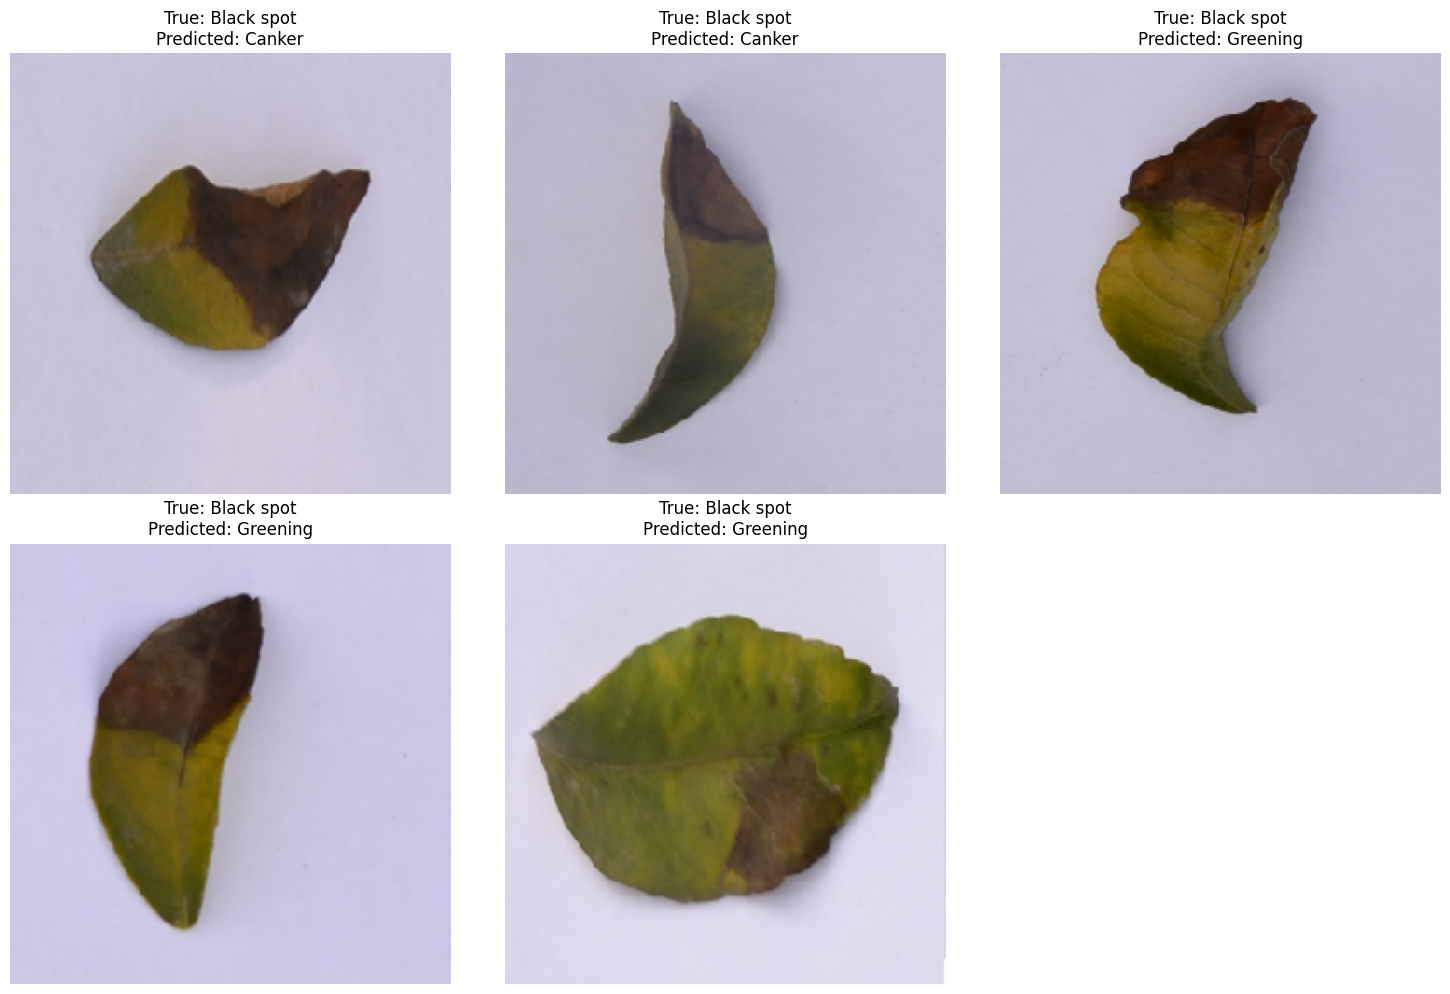

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
model_name = "InceptionV3"

print(f"--- Performing Error Analysis for {model_name} ---")

filenames = test_generator.filenames
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

Y_pred = model_inception.predict(test_generator)
predicted_labels = np.argmax(Y_pred, axis=1)

misclassified_indices = np.where(predicted_labels != true_labels)[0]
print(f"Found {len(misclassified_indices)} misclassified images.")

num_to_display = min(5, len(misclassified_indices))
if num_to_display > 0:
    plt.figure(figsize=(15, 5 * math.ceil(num_to_display/3)))
    for i, img_index in enumerate(misclassified_indices[:num_to_display]):
        img_path = os.path.join(test_dir, filenames[img_index])
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(Image_height, Image_width))
        plt.subplot(math.ceil(num_to_display/3), 3, i + 1)
        plt.imshow(img)
        true_label_name = class_names[true_labels[img_index]]
        predicted_label_name = class_names[predicted_labels[img_index]]
        plt.title(f"True: {true_label_name}\nPredicted: {predicted_label_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images found. The model is perfect on the test set!")

In [12]:
from google.colab import drive

drive.mount('/content/drive')


best_model = model_inception
best_model_name = "CitriScan_Best_Model_InceptionV3.keras"

model_save_path = f'/content/drive/MyDrive/{best_model_name}'

best_model.save(model_save_path)

print(f" Best model saved successfully to your Google Drive at: {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Best model saved successfully to your Google Drive at: /content/drive/MyDrive/CitriScan_Best_Model_InceptionV3.keras


In [13]:
!pip install streamlit -q

In [ ]:
!ls -R

In [ ]:
!pip install streamlit

In [14]:
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
from PIL import Image

# --- Custom Theme (light/dark mode example) ---
st.set_page_config(page_title="Image Classifier", layout="wide")
theme = st.sidebar.selectbox("Choose Theme", ["Light", "Dark"])
if theme == "Dark":
    st.markdown("""
        <style>
        body { background-color: #212121; color: #F9F9F9; }
        .stApp { background-color: #212121; color: #F9F9F9; }
        </style>
    """, unsafe_allow_html=True)

# --- TITLE AND DESCRIPTION ---
st.title("Deep Learning Image Classification (MobileNetV2 vs InceptionV3)")
st.write("Upload an image to compare predictions from two models. Advanced analytics are collapsible below.")

# --- Model Loading ---
@st.cache_resource
def load_models():
    mobilenet = tf.keras.models.load_model('mobilenetv2_model.keras')
    inception = tf.keras.models.load_model('inceptionv3_model.keras')
    return mobilenet, inception

mobilenet_model, inception_model = load_models()

# --- Upload and Preview Image ---
uploaded_file = st.file_uploader("Upload an image for prediction", type=["jpg", "jpeg", "png"])
if uploaded_file:
    image = Image.open(uploaded_file)
    img = image.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # --- Predict with Both Models ---
    preds_mobile = mobilenet_model.predict(img_array)[0]
    preds_inception = inception_model.predict(img_array)[0]

    class_names = ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']
    # --- SIDE-BY-SIDE COMPARISON ---
    cols = st.columns(2)
    with cols[0]:
        st.metric("MobileNetV2 Prediction", f"{class_names[np.argmax(preds_mobile)]}")
        st.bar_chart({c: preds_mobile[i] for i, c in enumerate(class_names)})
    with cols[1]:
        st.metric("InceptionV3 Prediction", f"{class_names[np.argmax(preds_inception)]}")
        st.bar_chart({c: preds_inception[i] for i, c in enumerate(class_names)})

    # Compare/Disagreement Highlight
    if np.argmax(preds_mobile) != np.argmax(preds_inception):
        st.warning(
            f"Disagreement! MobileNetV2 predicts '{class_names[np.argmax(preds_mobile)]}', InceptionV3 predicts '{class_names[np.argmax(preds_inception)]}'."
        )
    else:
        st.success(
            f"Both models agree on prediction: '{class_names[np.argmax(preds_mobile)]}'."
        )

# --- Collapsible Advanced Analytics ---
with st.expander("🔎 Advanced Model Analytics"):
    st.subheader("Model Parameters")
    st.markdown("""
        | Model          | Trainable Params | Total Params |
        |:--------------:|:----------------:|:------------:|
        | MobileNetV2    | 1,316,869        | 3,574,853    |
        | InceptionV3    | (fetch from logs)| (fetch logs) |
    """)
    st.caption("Edit above as per your actual model summaries.")

    st.subheader("Training Accuracy & Loss Plots")
    st.image('training_curve_mobilenet.png', caption="MobileNetV2 Training Curves")
    st.image('training_curve_inception.png', caption="InceptionV3 Training Curves")

    st.subheader("Usage Tips")
    st.write("""
        - Upload any JPG or PNG image in the sidebar.
        - Hover or tap bars for predicted probabilities.
        - Try switching to dark mode in sidebar.
        - Expand/collapse analytics for details.
    """)

# --- Footer ---
st.markdown("---")
st.markdown("Bhupinder Singh | Sustainable Agriculture")



Overwriting app.py


In [15]:
!wget -q -O - ipv4.icanhazip.com

34.48.37.210


In [16]:
! streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.48.37.210:8501

⠦⠧⠇⠏⠋your url is: https://shy-singers-sink.loca.lt
2025-09-14 17:44:40.520774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757871880.563280   17602 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757871880.576266   17602 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757871880.607406   17602 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757871880.607456  